In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import yfinance as yf
import tensorflow
import keras
import math

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [158]:
df = yf.download('MSFT', start='2019-12-01', end='2022-12-31', progress=False)

In [117]:
df.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-02,151.809998,151.830002,148.320007,149.550003,144.710251,27418400
2019-12-03,147.490005,149.429993,146.649994,149.309998,144.478058,24066000
2019-12-04,150.139999,150.179993,149.199997,149.850006,145.000610,17574700
2019-12-05,150.050003,150.320007,149.479996,149.929993,145.077988,17869100
2019-12-06,150.990005,151.869995,150.270004,151.750000,146.839096,16403500


In [118]:
df = df.drop(columns=['Adj Close'])
df.head(5)

,Open,High,Low,Close,Volume
Date,,,,,
2019-12-02,151.809998,151.830002,148.320007,149.550003,27418400
2019-12-03,147.490005,149.429993,146.649994,149.309998,24066000
2019-12-04,150.139999,150.179993,149.199997,149.850006,17574700
2019-12-05,150.050003,150.320007,149.479996,149.929993,17869100
2019-12-06,150.990005,151.869995,150.270004,151.750000,16403500


In [119]:
df.isna().any()

Open      False
High      False
Low       False
Close     False
Volume    False
dtype: bool

In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 777 entries, 2019-12-02 to 2022-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    777 non-null    float64
 1   High    777 non-null    float64
 2   Low     777 non-null    float64
 3   Close   777 non-null    float64
 4   Volume  777 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 36.4 KB


Text(0, 0.5, 'Historic Prices')

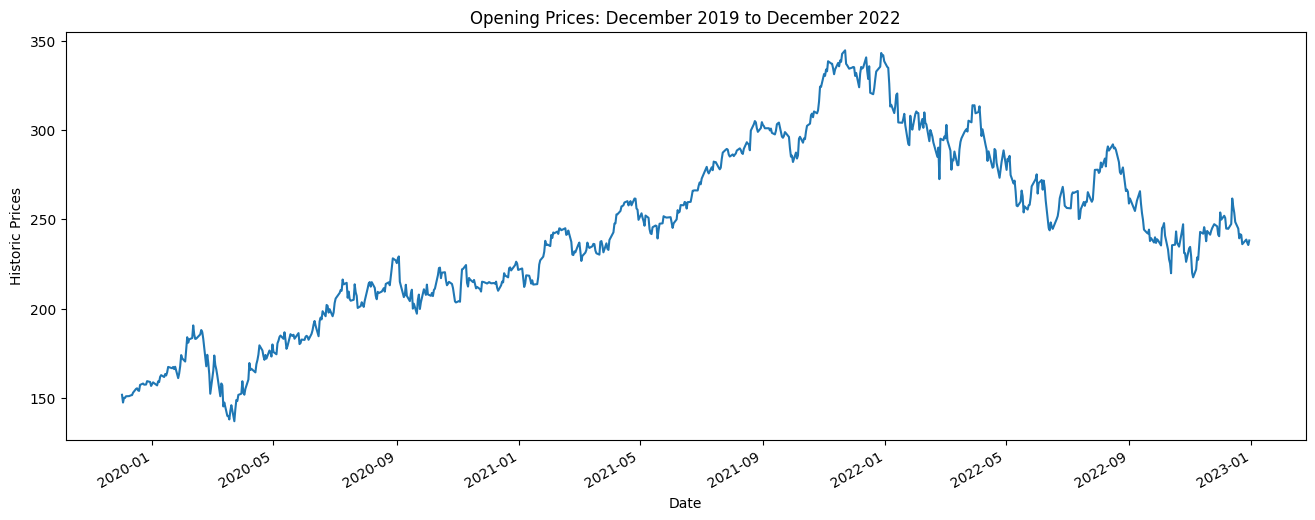

In [121]:
df['Open'].plot(figsize=(16,6))
plt.title('Opening Prices: December 2019 to December 2022')
plt.xlabel('Date')
plt.ylabel('Historic Prices')

In [122]:
df.rolling(7).mean().head(20)

,Open,High,Low,Close,Volume
Date,,,,,
2019-12-02,NaN,NaN,NaN,NaN,NaN
2019-12-03,NaN,NaN,NaN,NaN,NaN
2019-12-04,NaN,NaN,NaN,NaN,NaN
2019-12-05,NaN,NaN,NaN,NaN,NaN
2019-12-06,NaN,NaN,NaN,NaN,NaN
2019-12-09,NaN,NaN,NaN,NaN,NaN
2019-12-10,150.405716,151.104285,149.369999,150.411429,1.949931e+07
2019-12-11,150.367144,151.109998,149.657142,150.718571,1.827620e+07
2019-12-12,150.961428,151.682857,150.281429,151.280001,1.835421e+07


Text(0, 0.5, 'Historic Price')

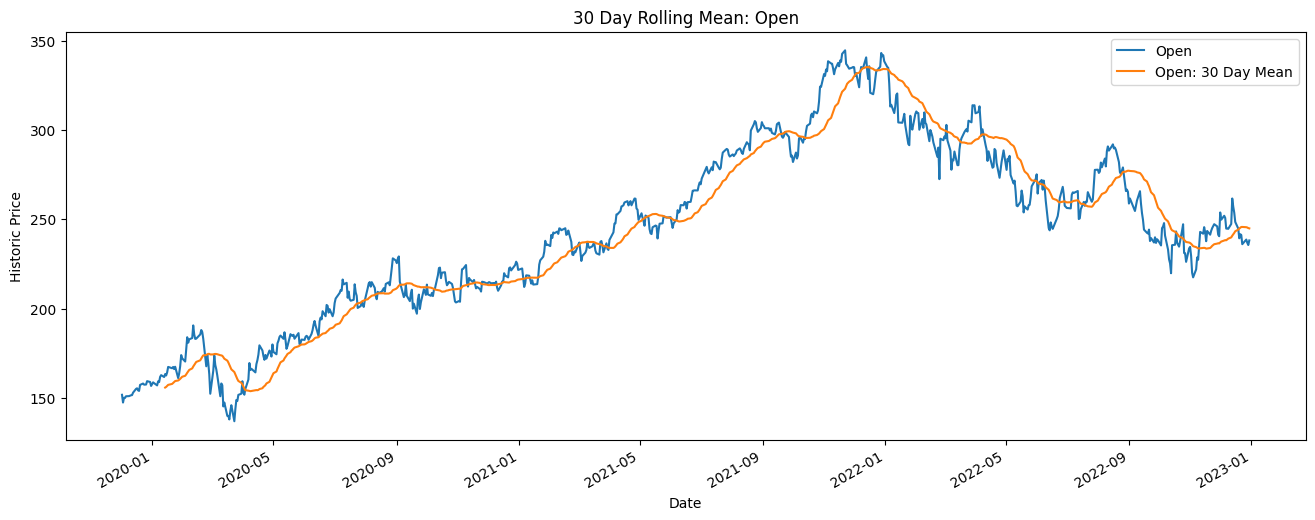

In [123]:
df['Open: 30 Day Mean'] = df['Open'].rolling(window=30).mean()
df[['Open','Open: 30 Day Mean']].plot(figsize=(16,6))
plt.title('30 Day Rolling Mean: Open')
plt.ylabel('Historic Price')

Text(0, 0.5, 'Historic Price')

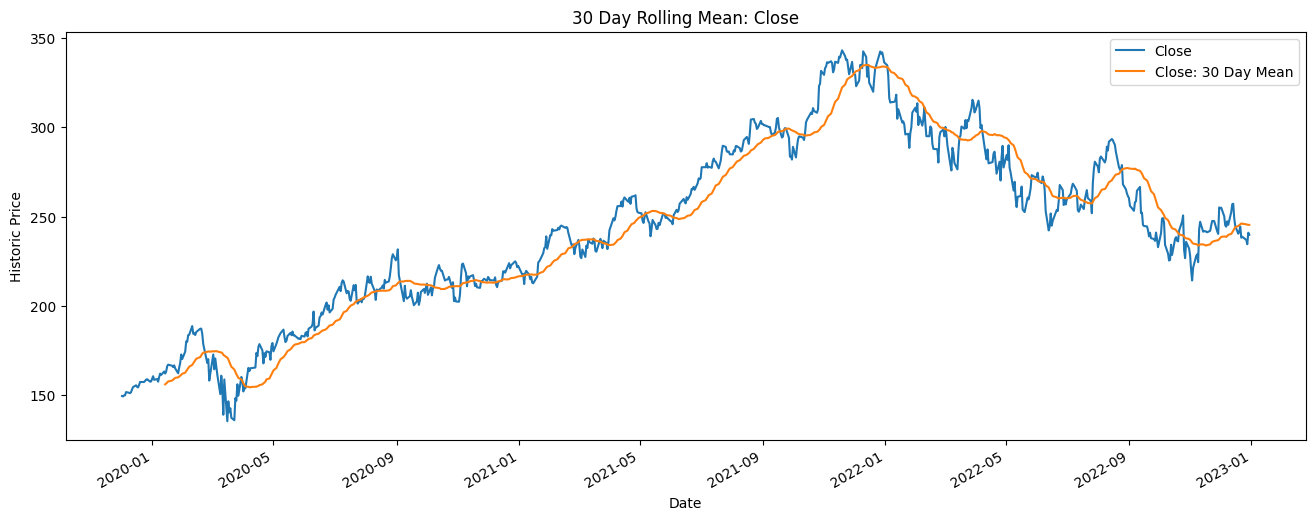

In [124]:
df['Close: 30 Day Mean'] = df['Close'].rolling(window=30).mean()
df[['Close','Close: 30 Day Mean']].plot(figsize=(16,6))
plt.title('30 Day Rolling Mean: Close')
plt.ylabel('Historic Price')

In [159]:
df_close = df.reset_index()['Close']
df_close

0      149.550003
1      149.309998
2      149.850006
3      149.929993
4      151.750000
          ...    
772    238.729996
773    236.960007
774    234.529999
775    241.009995
776    239.820007
Name: Close, Length: 777, dtype: float64

In [160]:
from sklearn.preprocessing import MinMaxScaler

#For LSTM scale of data is very sensitive so I am converting it to 0-1.
scaler = MinMaxScaler(feature_range = (0, 1))
df_close = scaler.fit_transform(np.array(df_close).reshape(-1,1))

In [161]:
df_close.shape

(777, 1)

In [162]:
#Array after conversion
df_close

array([[0.06803412],
       [0.06687852],
       [0.06947859],
       [0.06986372],
       [0.07862681],
       [0.07674902],
       [0.07564162],
       [0.07838606],
       [0.08580099],
       [0.09201214],
       [0.09682701],
       [0.09278254],
       [0.09124175],
       [0.09769373],
       [0.10587899],
       [0.10587899],
       [0.10573455],
       [0.1119457 ],
       [0.11334205],
       [0.10674563],
       [0.10727527],
       [0.12133467],
       [0.11170494],
       [0.11367905],
       [0.10669751],
       [0.1187828 ],
       [0.12841254],
       [0.12480139],
       [0.13414224],
       [0.12860517],
       [0.13366073],
       [0.14805721],
       [0.15253508],
       [0.14964613],
       [0.14579422],
       [0.1507054 ],
       [0.14261638],
       [0.12932737],
       [0.14463869],
       [0.15706099],
       [0.17988349],
       [0.16760556],
       [0.18758731],
       [0.21522461],
       [0.21416534],
       [0.23212485],
       [0.23337669],
       [0.256

In [163]:
training_size=int(len(df_close)*0.65)
test_size = len(df_close)-training_size
train_data,test_data=df_close[0:training_size],df_close[training_size:len(df_close),:1]

In [164]:
training_size,test_size

(505, 272)

In [165]:
def create_dataset(dataset, timestep=1):
  dataX, dataY=[],[]
  for i in range(len(dataset)-timestep-1):
    a=dataset[i:(i+timestep),0]
    dataX.append(a)
    dataY.append(dataset[i+timestep,0])
  return np.array(dataX),np.array(dataY)

In [166]:
timestep=100
x_train,y_train=create_dataset(train_data,timestep)
x_test,y_test=create_dataset(test_data,timestep)

In [167]:
x_train

array([[0.06803412, 0.06687852, 0.06947859, ..., 0.18344652, 0.17333527,
        0.18840583],
       [0.06687852, 0.06947859, 0.06986372, ..., 0.17333527, 0.18840583,
        0.1859984 ],
       [0.06947859, 0.06986372, 0.07862681, ..., 0.18840583, 0.1859984 ,
        0.16558333],
       ...,
       [0.69579664, 0.68371142, 0.68621509, ..., 0.98420724, 0.9738553 ,
        0.97496277],
       [0.68371142, 0.68621509, 0.6832299 , ..., 0.9738553 , 0.97496277,
        0.93533635],
       [0.68621509, 0.6832299 , 0.70085234, ..., 0.97496277, 0.93533635,
        0.96879975]])

In [168]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(404, 100)
(404,)
(171, 100)
(171,)


In [169]:
#for LSTM reshape into 3 dimenstion array
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [170]:
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [171]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 100, 50)           10400     
                                                                 
 lstm_13 (LSTM)              (None, 100, 50)           20200     
                                                                 
 lstm_14 (LSTM)              (None, 50)                20200     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [138]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
7/7 [==============================] - 9s 407ms/step - loss: 0.1146 - val_loss: 0.0897
Epoch 2/100
7/7 [==============================] - 2s 251ms/step - loss: 0.0180 - val_loss: 0.0154
Epoch 3/100
7/7 [==============================] - 2s 343ms/step - loss: 0.0123 - val_loss: 0.0102
Epoch 4/100
7/7 [==============================] - 1s 211ms/step - loss: 0.0076 - val_loss: 0.0052
Epoch 5/100
7/7 [==============================] - 1s 215ms/step - loss: 0.0041 - val_loss: 0.0036
Epoch 6/100
7/7 [==============================] - 2s 241ms/step - loss: 0.0032 - val_loss: 0.0082
Epoch 7/100
7/7 [==============================] - 1s 209ms/step - loss: 0.0024 - val_loss: 0.0044
Epoch 8/100
7/7 [==============================] - 1s 213ms/step - loss: 0.0020 - val_loss: 0.0077
Epoch 9/100
7/7 [==============================] - 1s 210ms/step - loss: 0.0020 - val_loss: 0.0048
Epoch 10/100
7/7 [==============================] - 2s 264ms/step - loss: 0.0021 - val_loss: 0.0072
Epoch 11/

In [172]:
train_predict=model.predict(x_train)
test_predict=model.predict(x_test)

6/6 [==============================] - 0s 58ms/step


In [173]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [174]:
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

137.66311179725608

In [142]:
math.sqrt(mean_squared_error(y_test,test_predict))

261.34590764161527

In [143]:
look_back=100
trainPredictPlot=np.empty_like(df_close)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back,:]=train_predict

testPredictPlot=np.empty_like(df_close)
testPredictPlot[:, :]=np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df_close)-1,:]=test_predict

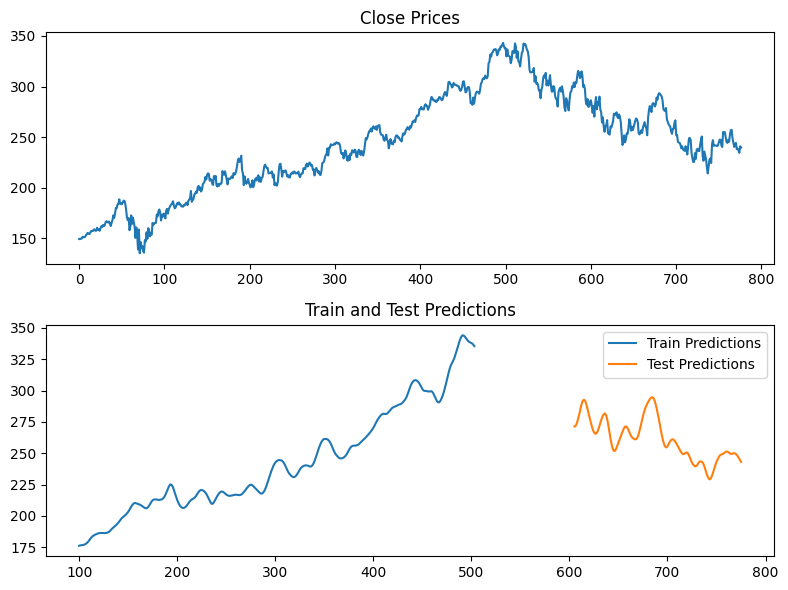

In [144]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))

axes[0].plot(scaler.inverse_transform(df_close))
axes[0].set_title("Close Prices")

axes[1].plot(trainPredictPlot, label="Train Predictions")

axes[1].plot(testPredictPlot, label="Test Predictions")

axes[1].set_title("Train and Test Predictions")
axes[1].legend()

plt.tight_layout()
plt.show()

In [175]:
len(test_data)

272

In [176]:
x_input=test_data[172:].reshape(1,-1)
x_input.shape

(1, 100)

In [177]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [148]:
temp_input

[0.7402379266265924,
 0.729934037269828,
 0.7534788153054577,
 0.7609899985827817,
 0.7573306514186031,
 0.7506380604578402,
 0.745100990943395,
 0.7257451250887965,
 0.6853002581482519,
 0.6789927920235519,
 0.6758631568143549,
 0.690596643007424,
 0.6387886097382804,
 0.6250181560425625,
 0.6141365059626391,
 0.6069142030468944,
 0.6017622583685123,
 0.580865746231533,
 0.5673359771910882,
 0.5906399236333157,
 0.5927102818706782,
 0.6213106131720776,
 0.6318551871841152,
 0.5612692691907257,
 0.5623766683998019,
 0.5294429847365816,
 0.5263614717646263,
 0.525302194792792,
 0.5153353815039132,
 0.49848334136717565,
 0.5082575187689582,
 0.4935240325758894,
 0.4912610384514309,
 0.4862536074229029,
 0.508690912780392,
 0.49150179657576865,
 0.469353371579859,
 0.5071019973226405,
 0.5462950248733192,
 0.5478357446247646,
 0.5362318936408925,
 0.4758053513544134,
 0.4517791305391725,
 0.4332900527074417,
 0.43492709040243493,
 0.4758053513544134,
 0.4484568594428797,
 0.49164623675655

In [178]:
lst_output=[]
n_steps=100
i=0
while(i<30):#if we are prdicting for 30 days
    if(len(temp_input)>100):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


print(lst_output)

[0.01470986]
101
1 day input [0.72993404 0.75347882 0.76099    0.75733065 0.75063806 0.74510099
 0.72574513 0.68530026 0.67899279 0.67586316 0.69059664 0.63878861
 0.62501816 0.61413651 0.6069142  0.60176226 0.58086575 0.56733598
 0.59063992 0.59271028 0.62131061 0.63185519 0.56126927 0.56237667
 0.52944298 0.52636147 0.52530219 0.51533538 0.49848334 0.50825752
 0.49352403 0.49126104 0.48625361 0.50869091 0.4915018  0.46935337
 0.507102   0.54629502 0.54783574 0.53623189 0.47580535 0.45177913
 0.43329005 0.43492709 0.47580535 0.44845686 0.49164624 0.49631667
 0.48659061 0.48500169 0.51374647 0.53844677 0.55486549 0.46174594
 0.43974196 0.48365354 0.46564598 0.44657906 0.40772311 0.3795561
 0.41393426 0.44513459 0.44994946 0.42895663 0.51788726 0.53777269
 0.51100203 0.51302427 0.51186867 0.51162791 0.50941311 0.51340946
 0.52775775 0.54003568 0.53960236 0.51201311 0.50512788 0.57643608
 0.5742694  0.57585832 0.55265061 0.52819107 0.52457992 0.53916897
 0.52963555 0.56377295 0.58500661 

In [179]:
day_new=np.arange(1,101)#100 stepss
day_pred=np.arange(101,131)#30 days

In [180]:
len(df_close)

777

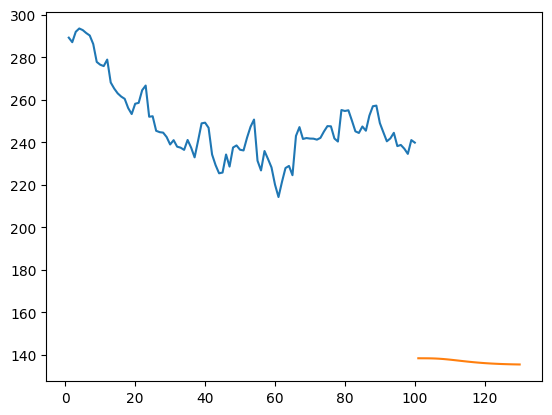

In [181]:
plt.plot(day_new,scaler.inverse_transform(df_close[677:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

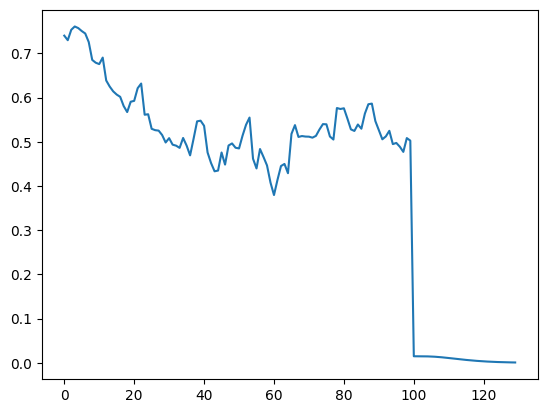

In [183]:
df3=df_close.tolist()
df3.extend(lst_output)
plt.plot(df3[677:])

In [184]:
btc3=scaler.inverse_transform(df3).tolist()

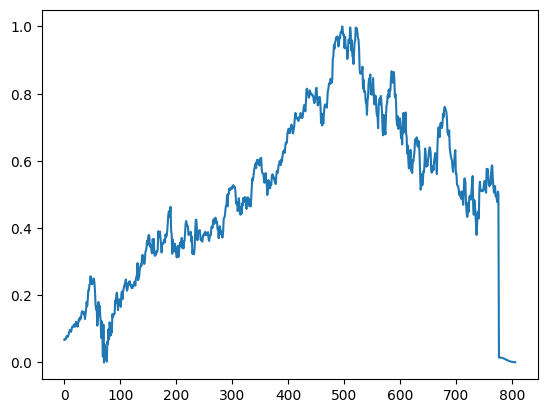

In [185]:
plt.plot(df3)